In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio

import nibabel as nib



In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 136]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1c')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask

In [3]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="PED_Sliced/axial/t1c", t2f_dir="PED_Sliced/axial/t2f", seg_dir="PED_Sliced/axial/seg", transforms=data_transforms)

In [4]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=True)

In [5]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)



4324
181
Data shape: torch.Size([24, 2, 240, 240])
Labels shape: torch.Size([24, 240, 240])
Data shape: torch.Size([24, 2, 240, 240])
Labels shape: torch.Size([24, 240, 240])


In [6]:
# import torch
# import torch.nn as  nn
# import torch.nn.functional as F


# class Bottleneck(nn.Module):
#     expansion = 4
#     def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
#         super(Bottleneck, self).__init__()
        
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
#         self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
#         self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
#         self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
#         self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
#         self.i_downsample = i_downsample
#         self.stride = stride
#         self.relu = nn.ReLU()
        
#     def forward(self, x):
#         identity = x.clone()
#         x = self.relu(self.batch_norm1(self.conv1(x)))
        
#         x = self.relu(self.batch_norm2(self.conv2(x)))
        
#         x = self.conv3(x)
#         x = self.batch_norm3(x)
        
#         #downsample if needed
#         if self.i_downsample is not None:
#             identity = self.i_downsample(identity)
#         #add identity
#         x+=identity
#         x=self.relu(x)
        
#         return x

# class Block(nn.Module):
#     expansion = 1
#     def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
#         super(Block, self).__init__()
       

#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
#         self.batch_norm1 = nn.BatchNorm2d(out_channels)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
#         self.batch_norm2 = nn.BatchNorm2d(out_channels)

#         self.i_downsample = i_downsample
#         self.stride = stride
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         identity = x.clone()

#         x = self.relu(self.batch_norm2(self.conv1(x)))
#         x = self.batch_norm2(self.conv2(x))

#         if self.i_downsample is not None:
#             identity = self.i_downsample(identity)
#         print(x.shape)
#         print(identity.shape)
#         x += identity
#         x = self.relu(x)
#         return x


        
        
# class ResNet50(nn.Module):
#     def __init__(self, ResBlock, layer_list, num_classes, num_channels=2, image_size=(240, 240)):
#         super(ResNet, self).__init__()
#         self.in_channels = 64
#         self.image_size = image_size

#         self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=1, padding=3, bias=False)
#         self.batch_norm1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU()

#         self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
#         self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128)
#         self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256)
#         self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512)

#         self.conv_final = nn.Conv2d(512 * ResBlock.expansion, num_classes, kernel_size=1)

#     def forward(self, x):
#         x = self.relu(self.batch_norm1(self.conv1(x)))

#         x = self.layer1(x)
#         x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

#         x = self.layer2(x)
#         x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

#         x = self.layer3(x)
#         x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

#         x = self.layer4(x)
#         x = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=False)

#         x = self.conv_final(x)
#         x = F.interpolate(x, size=self.image_size, mode='bilinear', align_corners=False)

#         return x

        
#     def _make_layer(self, ResBlock, blocks, planes, stride=1):
#         ii_downsample = None
#         layers = []
        
#         if stride != 1 or self.in_channels != planes*ResBlock.expansion:
#             ii_downsample = nn.Sequential(
#                 nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
#                 nn.BatchNorm2d(planes*ResBlock.expansion)
#             )
            
#         layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
#         self.in_channels = planes*ResBlock.expansion
        
#         for i in range(blocks-1):
#             layers.append(ResBlock(self.in_channels, planes))
            
#         return nn.Sequential(*layers)

        
        
# # def ResNet50(num_classes, channels=3):
# #     return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    
# # def ResNet101(num_classes, channels=3):
# #     return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

# # def ResNet152(num_classes, channels=3):
# #     return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)


In [13]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.conv(x)

    
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(F.relu(g1 + x1, inplace=True))
        return x * psi

class ResUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResUNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom
        self.conv5 = self.double_conv(512, 1024)

        # Attention blocks
        self.attention_block1 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.attention_block2 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.attention_block3 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.attention_block4 = AttentionBlock(F_g=64, F_l=64, F_int=32)

        # Residual blocks
        self.residual_block1 = ResidualBlock(1024)
        self.residual_block2 = ResidualBlock(512)
        self.residual_block3 = ResidualBlock(256)
        self.residual_block4 = ResidualBlock(128)

        # Upsample path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = self.double_conv(128, 64)

        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottom
        c5 = self.conv5(p4)
        c5 = self.residual_block1(c5)

        # Upsample path
        up6 = F.interpolate(self.up6(c5), size=c4.size()[2:], mode='bilinear', align_corners=False)
        attention_map1 = self.attention_block1(up6, c4)
        merge6 = torch.cat([up6, attention_map1], dim=1)
        c6 = self.conv6(merge6)
        c6 = self.residual_block2(c6)

        up7 = F.interpolate(self.up7(c6), size=c3.size()[2:], mode='bilinear', align_corners=False)
        attention_map2 = self.attention_block2(up7, c3)
        merge7 = torch.cat([up7, attention_map2], dim=1)
        c7 = self.conv7(merge7)
        c7 = self.residual_block3(c7)

        up8 = F.interpolate(self.up8(c7), size=c2.size()[2:], mode='bilinear', align_corners=False)
        attention_map3 = self.attention_block3(up8, c2)
        merge8 = torch.cat([up8, attention_map3], dim=1)
        c8 = self.conv8(merge8)
        c8 = self.residual_block4(c8)

        up9 = F.interpolate(self.up9(c8), size=c1.size()[2:], mode='bilinear', align_corners=False)
        attention_map4 = self.attention_block4(up9, c1)
        merge9 = torch.cat([up9, attention_map4], dim=1)
        c9 = self.conv9(merge9)

        # Output
        out = self.conv10(c9)
        return out

    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds


In [14]:


def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()



In [15]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)



In [16]:
from tqdm import tqdm

def train_model(num_epochs):
    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    model_path = "resUnet_PED_axial.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = ResUNet(2,4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = ResUNet(2,4).to(device)
        print("New model initialized.")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")
        running_loss = 0.0
        num_batches = 0
        running_train_dsc = []
        running_train_assd = []

        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
            masks = masks.long()

            outputs = model(images)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
                plot_preds_and_masks(preds, masks[:2])

            running_loss += loss.item()
            num_batches += 1

        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")

        model.eval()  
        running_val_loss = 0.0
        num_val_batches = 0

        with torch.no_grad():  
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device).long()

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                running_val_loss += val_loss.item()
                num_val_batches += 1

                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    plot_preds_and_masks(preds, val_masks[:2])

        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")

        torch.save(model.state_dict(), "resUnet_PED_axial.pth")

    return model


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/50
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


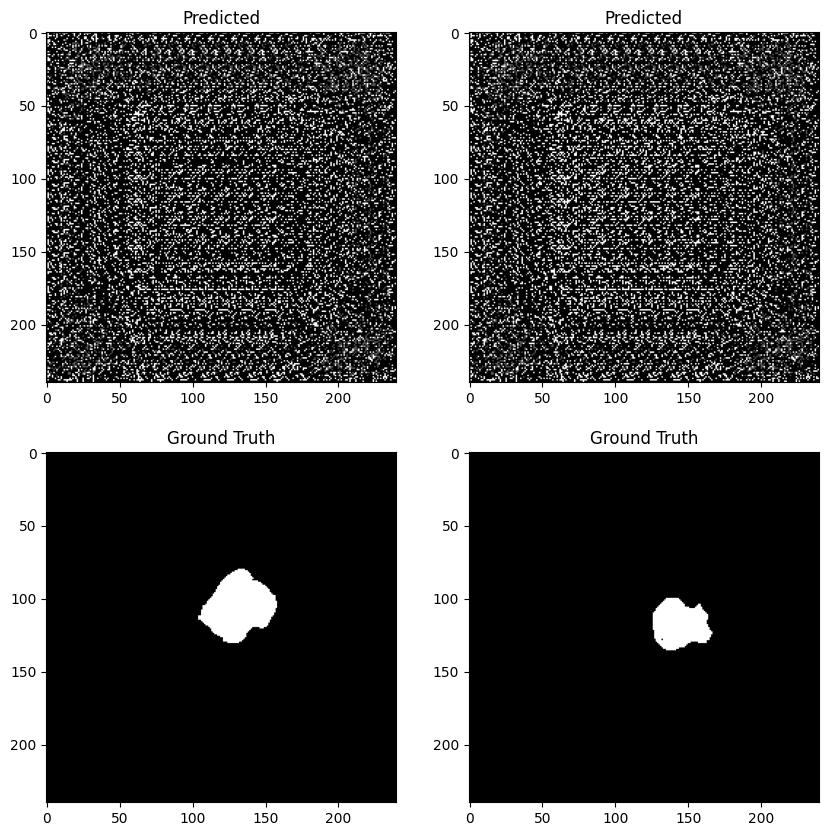

100%|██████████| 181/181 [02:25<00:00,  1.24it/s]



Average Training Loss: 0.2299218459970714


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


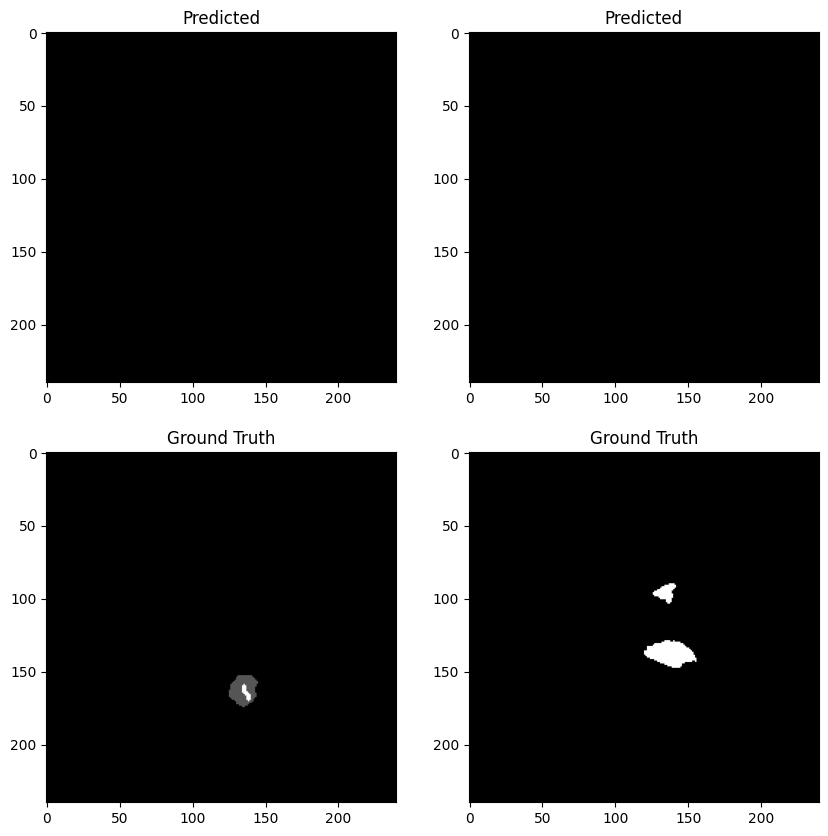

100%|██████████| 46/46 [00:19<00:00,  2.41it/s]


Average Validation Loss: 0.06438518590901209
Epoch 2/50
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


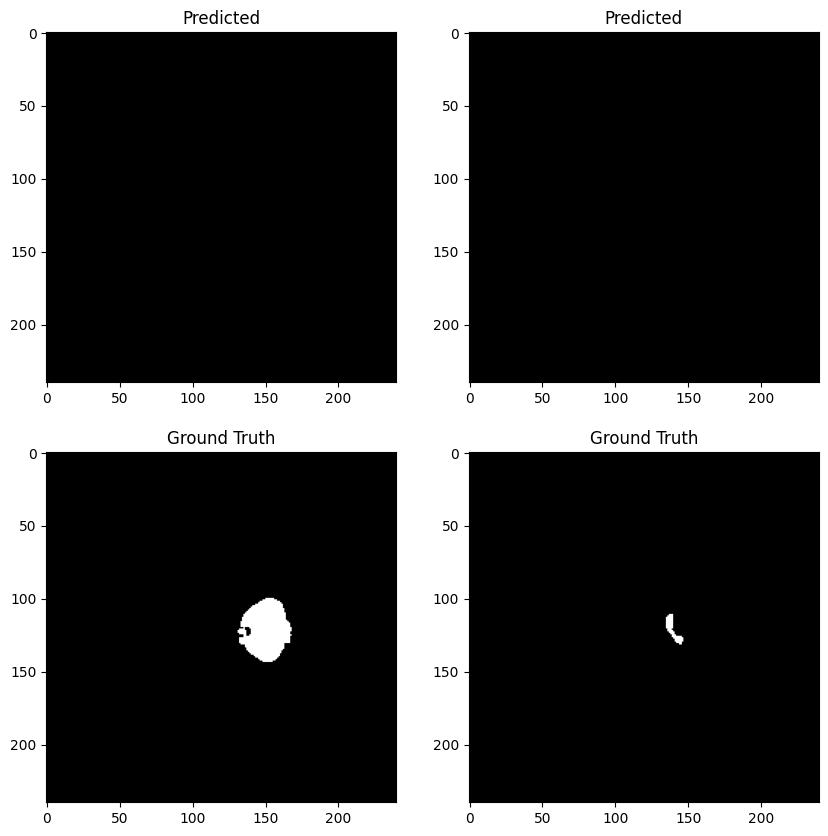

100%|██████████| 181/181 [02:16<00:00,  1.33it/s]



Average Training Loss: 0.050031947970225664


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


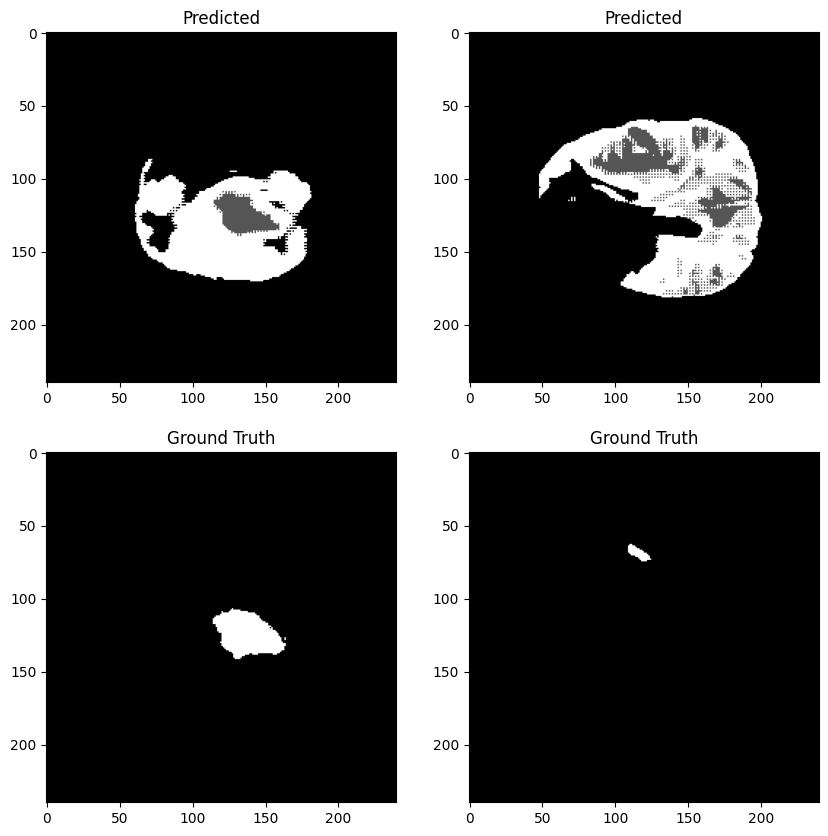

100%|██████████| 46/46 [00:17<00:00,  2.68it/s]


Average Validation Loss: 0.21482135517441708
Epoch 3/50
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


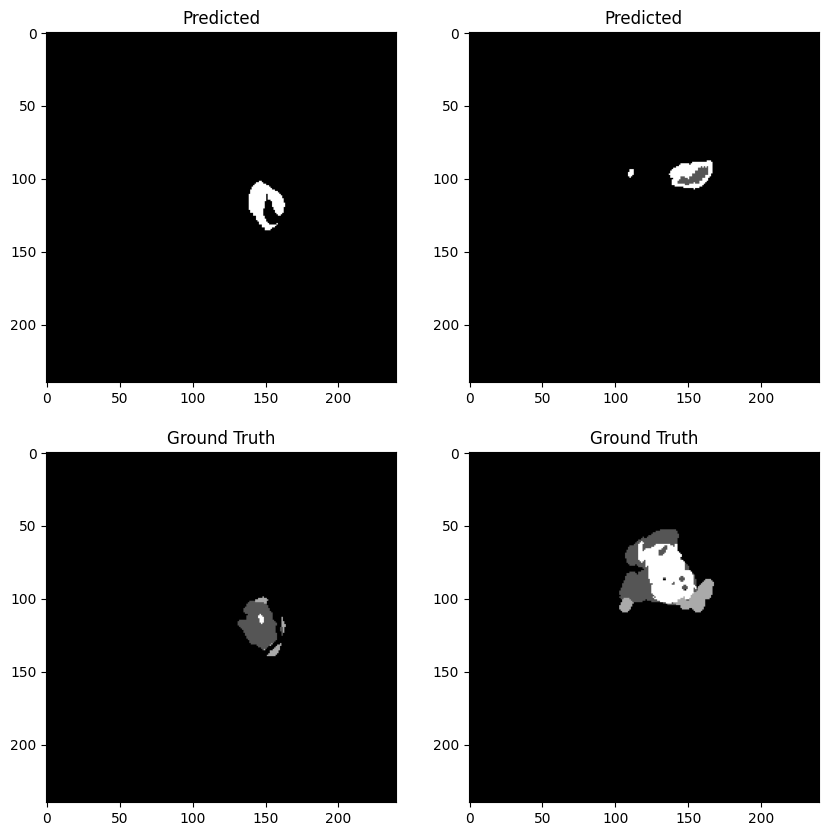

100%|██████████| 181/181 [02:16<00:00,  1.33it/s]



Average Training Loss: 0.043185602472220336


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


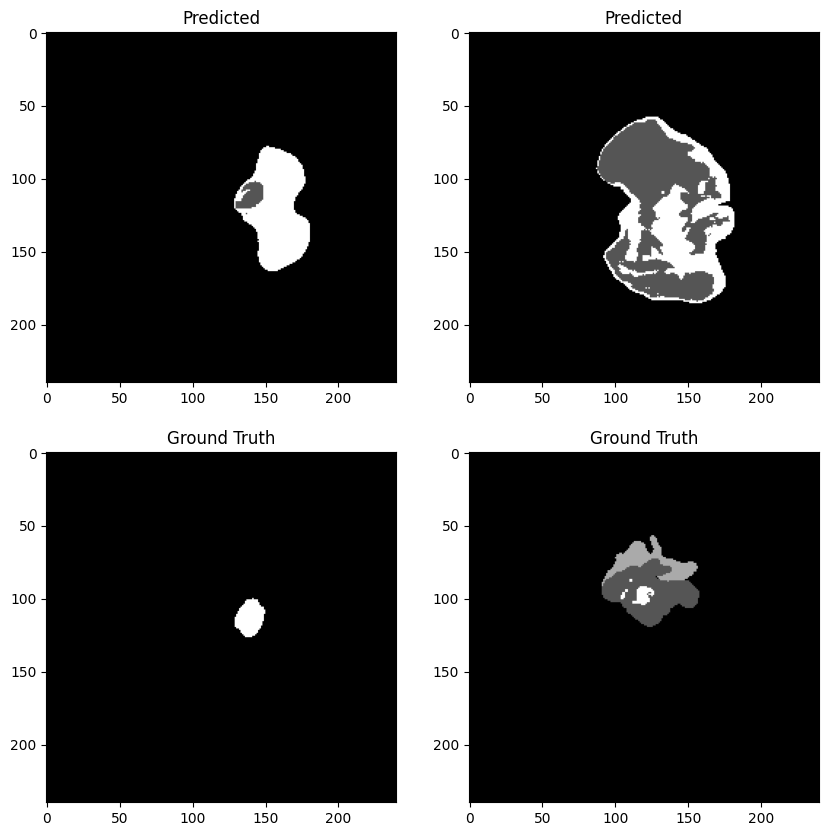

100%|██████████| 46/46 [00:17<00:00,  2.63it/s]


Average Validation Loss: 0.28840893377428467
Epoch 4/50
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


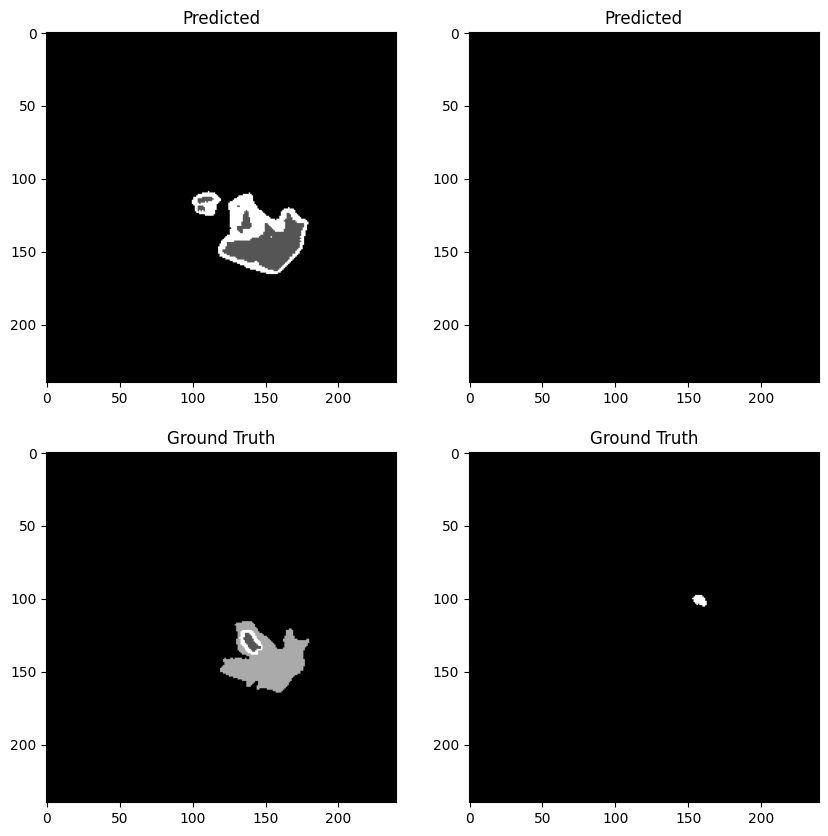

100%|██████████| 181/181 [02:16<00:00,  1.32it/s]



Average Training Loss: 0.03994525299093671


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


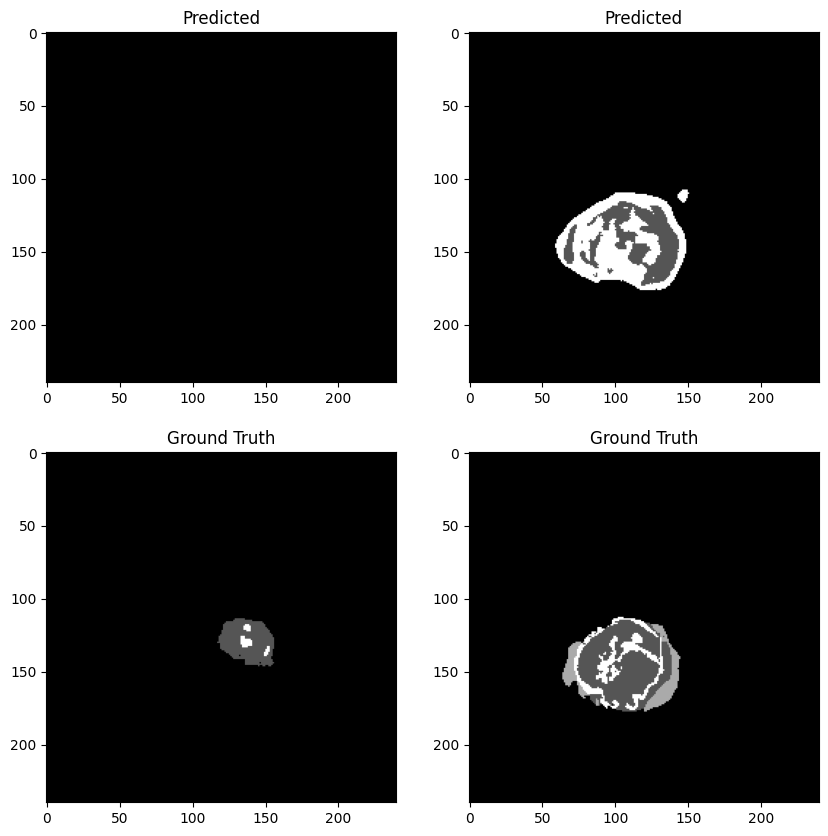

100%|██████████| 46/46 [00:17<00:00,  2.60it/s]


Average Validation Loss: 0.08982439284496334
Epoch 5/50
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


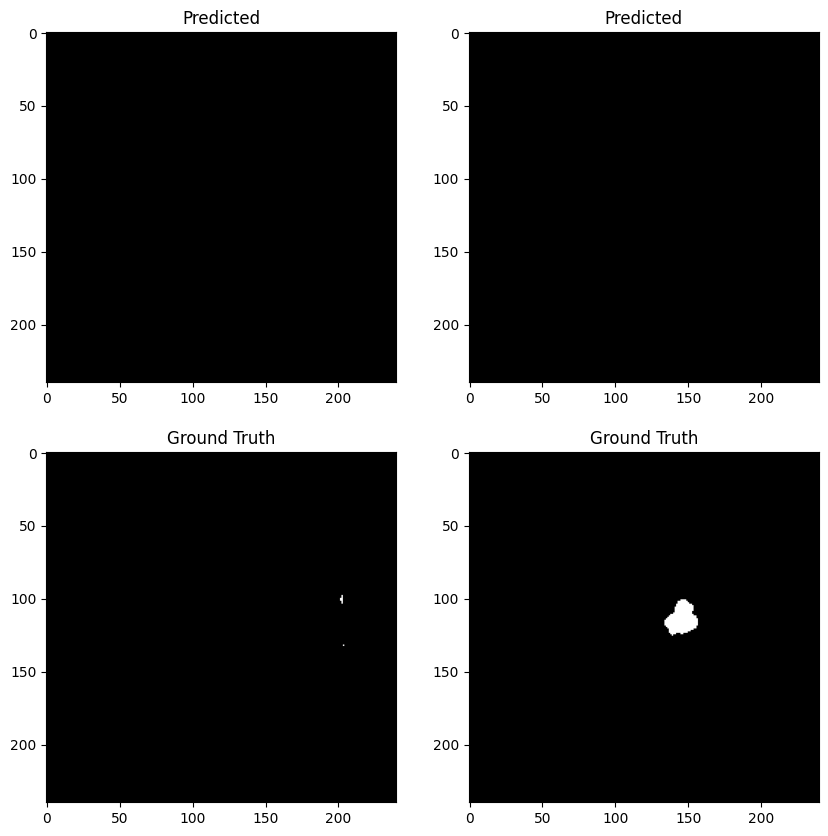

100%|██████████| 181/181 [02:18<00:00,  1.31it/s]



Average Training Loss: 0.03909535359241356


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


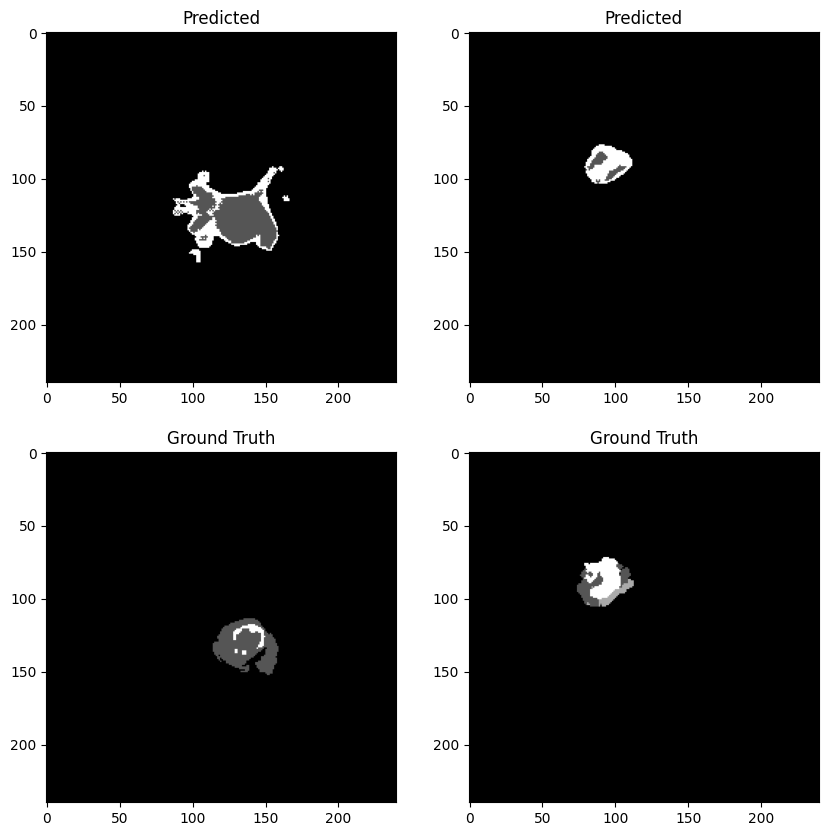

100%|██████████| 46/46 [00:17<00:00,  2.62it/s]


Average Validation Loss: 0.04410722710030234
Epoch 6/50
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


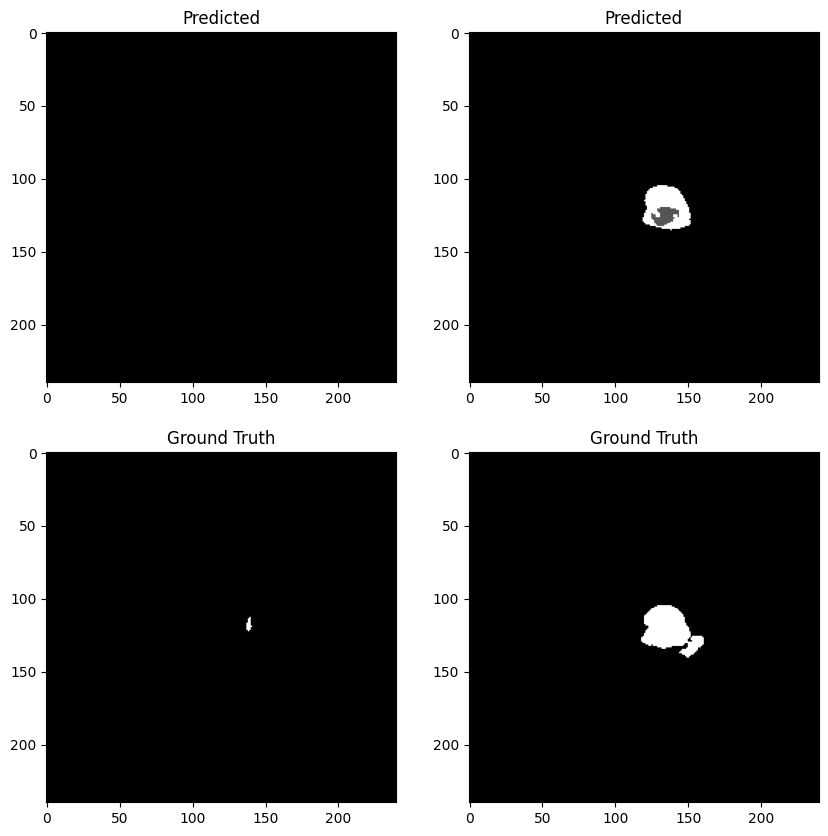

100%|██████████| 181/181 [02:15<00:00,  1.33it/s]



Average Training Loss: 0.03533887595596893


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


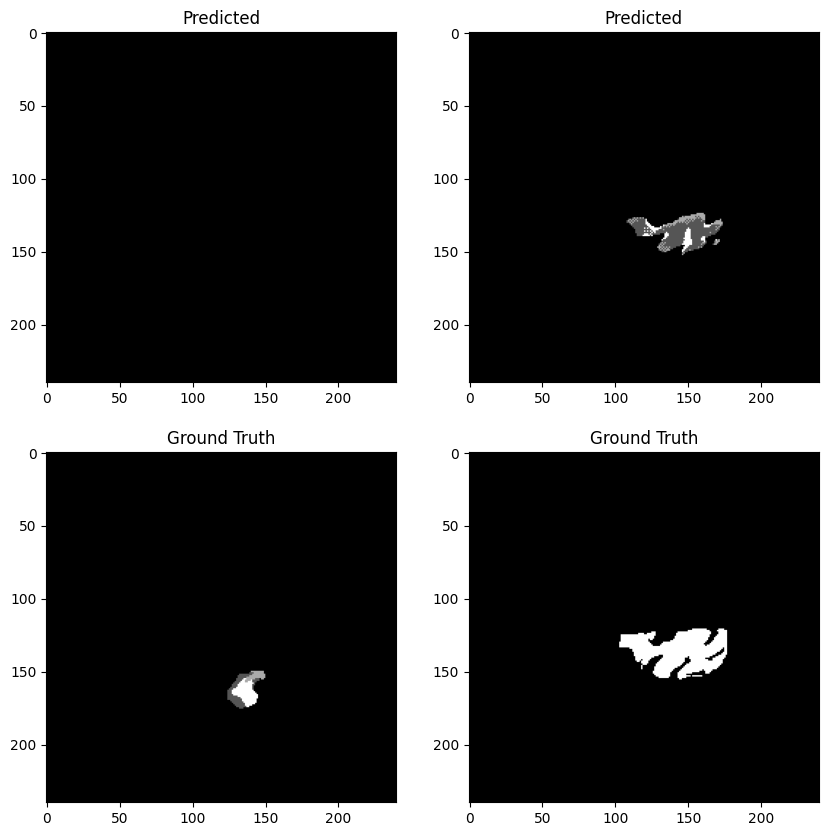

100%|██████████| 46/46 [00:17<00:00,  2.70it/s]


Average Validation Loss: 0.04302114840475437
Epoch 7/50
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


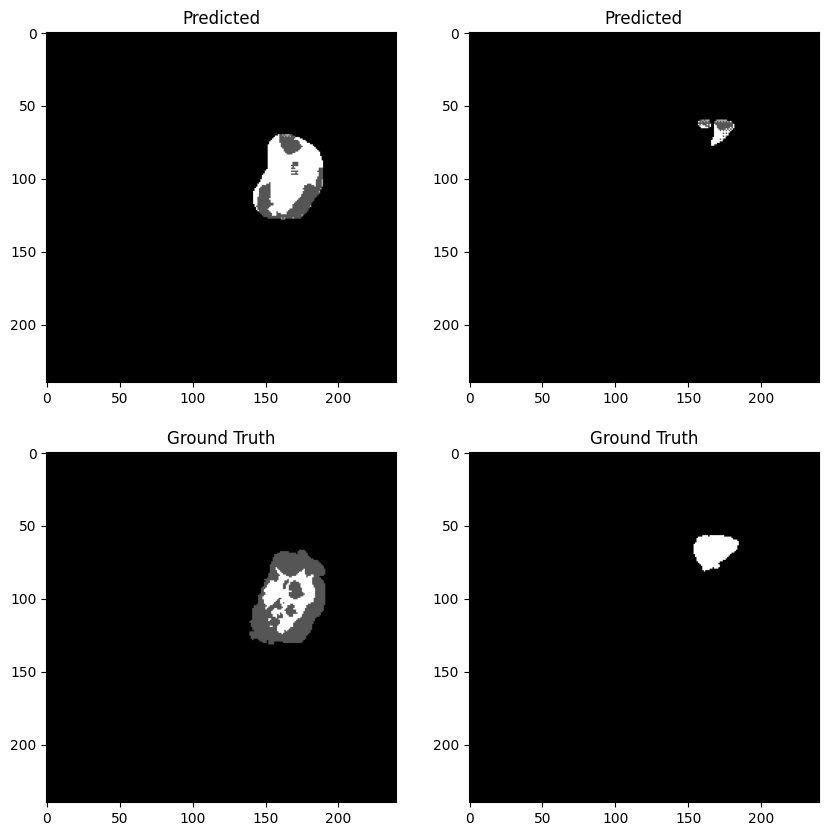

100%|██████████| 181/181 [02:16<00:00,  1.32it/s]



Average Training Loss: 0.032692941811285625


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


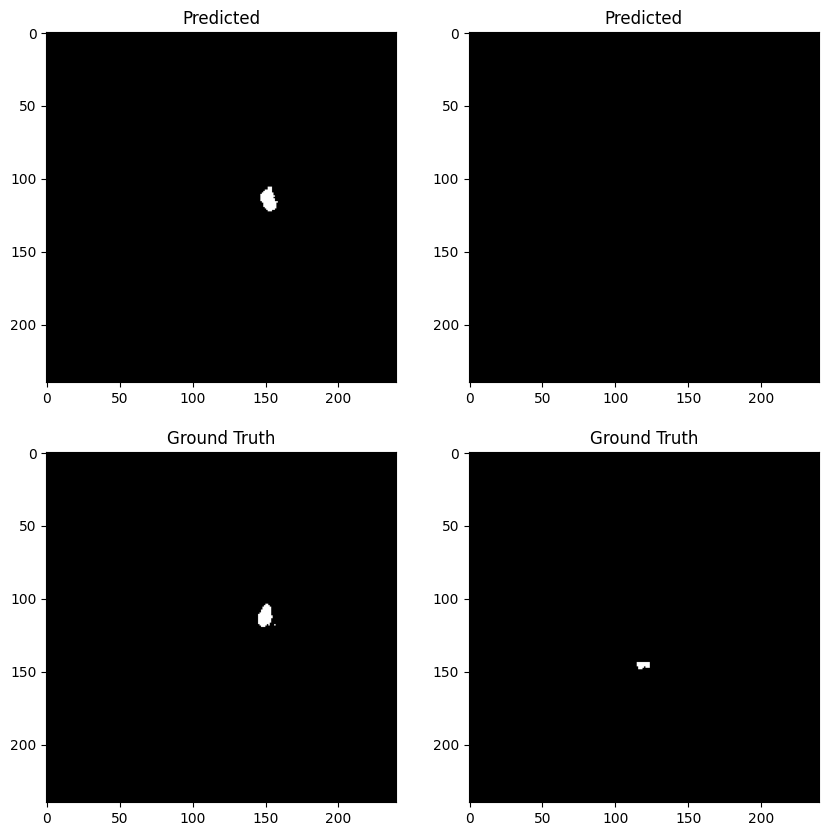

100%|██████████| 46/46 [00:17<00:00,  2.68it/s]


Average Validation Loss: 0.04482506863448931
Epoch 8/50
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


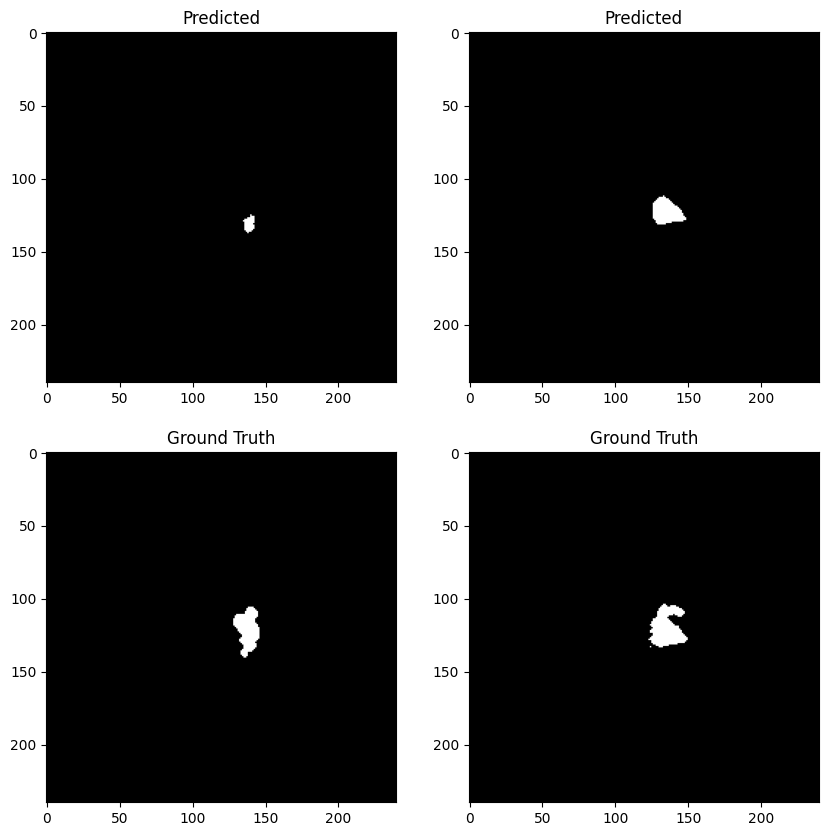

100%|██████████| 181/181 [02:15<00:00,  1.33it/s]



Average Training Loss: 0.030989062787131382


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


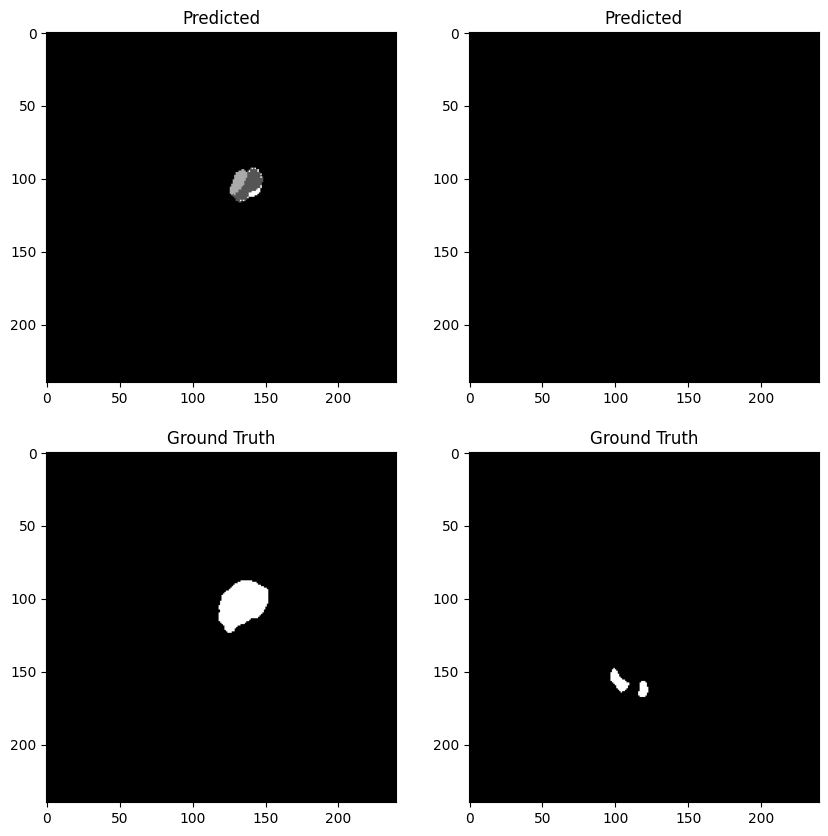

100%|██████████| 46/46 [00:17<00:00,  2.65it/s]


Average Validation Loss: 0.03424395479099906
Epoch 9/50
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


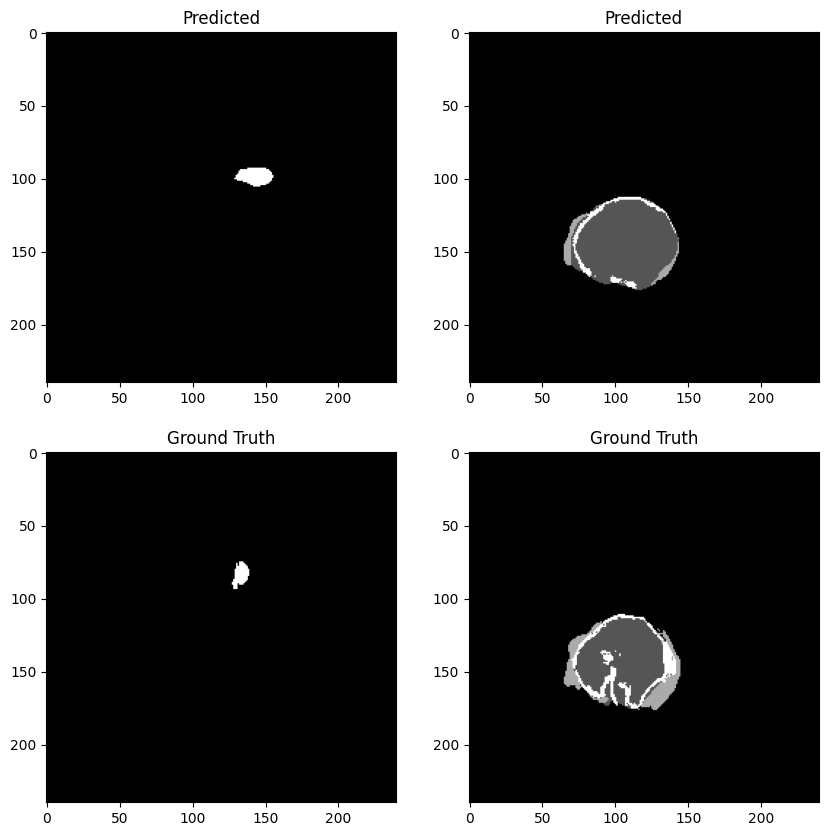

100%|██████████| 181/181 [02:16<00:00,  1.33it/s]



Average Training Loss: 0.027907340586679416


  0%|          | 0/46 [00:00<?, ?it/s]

Validation Prediction Visualization:


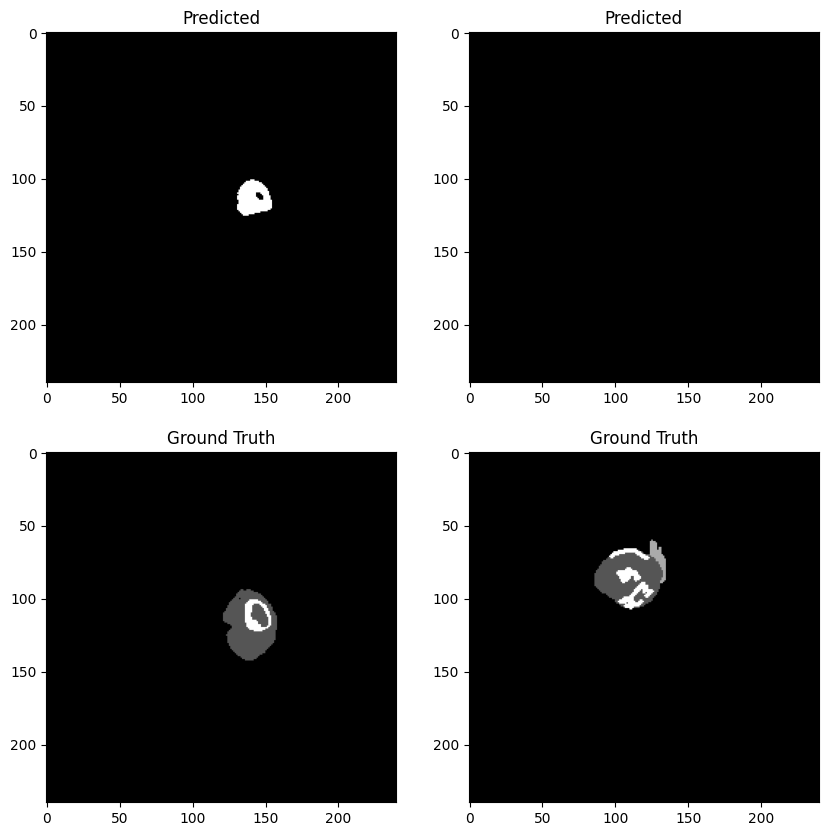

100%|██████████| 46/46 [00:17<00:00,  2.58it/s]


Average Validation Loss: 0.08265817035799441
Epoch 10/50
-------------------------


  0%|          | 0/181 [00:00<?, ?it/s]

Training Prediction Visualization:


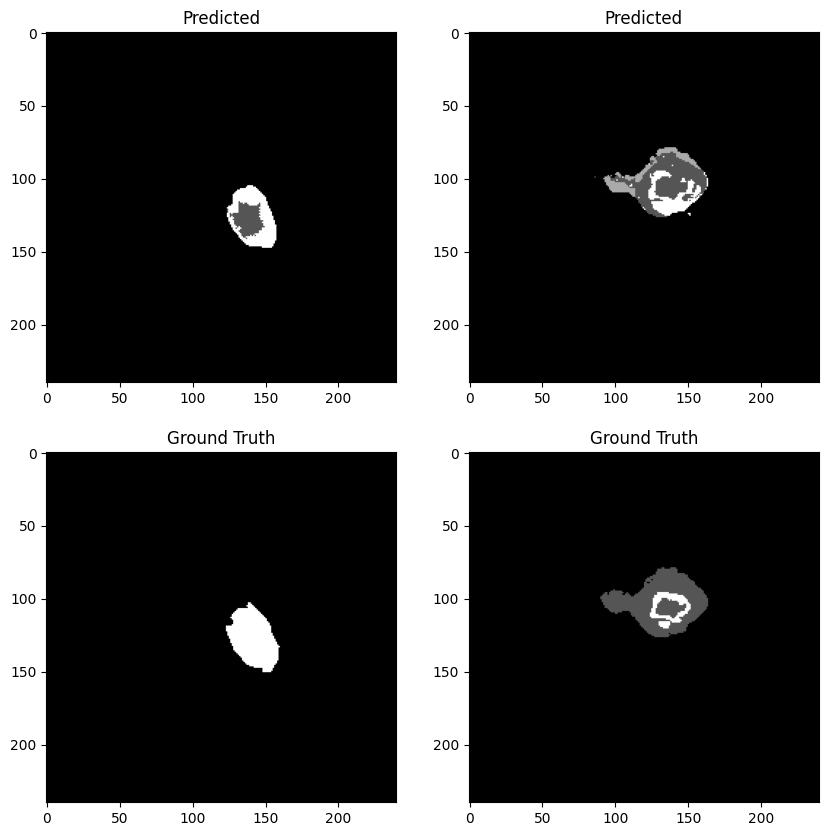

  6%|▌         | 10/181 [00:08<02:10,  1.31it/s]

In [ ]:
model = train_model(num_epochs = 50)